# Стратегия взаимодействия с пользователями в фитнес-центре.

1. [**Подготовка данных к анализу.**](#100101)
*******************************
2. [**Исследовательский анализ данных.**](#100102)
    * [2.1.Матрица корреляции для всех признаков. Промежуточные выводы.](#102100)
    * [2.2.Корреляция признаков для ушедших пользователей.](#102101)
    * [2.3.Корреляция признаков для оставшихся пользователей.](#102102)
    * [2.4.Средние показатели признаков для ушедших пользователей.](#102103)
    * [2.5.Средние показатели признаков для оставшихся пользователей.](#102104)
    * [2.6.Средние значения признаков разделенные по оттоку.](#102105)
    * [2.7.Предварительные выводы.](#102106)
*******************************
3. [**Модель прогнозирования оттока пользователей.**](#100103)
    * [3.1.Модель случайного леса.](#103100)
    * [3.2.Модель логистической регрессии.](#103101)
*******************************
4. [**Кластеризация пользователей.**](#100104)
    * [4.1.Дендрограмма кластеров. Коэффициент силуэта.](#104100)
    * [4.2.K-means. Статистика значений кластера.](#104101)
    * [4.3.График для пары признаков "дополнительные расходы" и "частота посещений за все время".](#104102)
    * [4.4.График для пары признаков "lifetime" и "срок до окончания абонемента".](#104103)
    * [4.5.График для пары признаков "другие расходы" и "возраст".](#104104)
    * [4.6.График для пары признаков "частота посещений за все время" и "частота посещений в последний месяц".](#104105)
*************************************
5. [**Выводы.**](#100105)
**************************************
6. [**Базовые рекомендации по работе с клиентами.**](#100106)

In [2]:
import pandas as pd
import warnings
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import ml_metrics, string, re, pylab as pl
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

#from pandas.plotting import register_matplotlib_converters
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
from numpy import median
from pandas.plotting import scatter_matrix
import sys; print(sys.version)

import joblib
from joblib import dump

import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from searchgrid import set_grid, make_grid_search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import precision_recall_curve, classification_report

pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


### 1. Подготовка данных к анализу <a id='100101'></a>

* *Прочитаем таблицу и посмотрим на параметры*

In [3]:
path = 'gym_churn.csv'
data=pd.read_csv(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null int64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(3), int64(11)
memory usage: 437.6 KB


In [4]:
data.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

* В нашей таблице 14 колонок и 4000 строк. 
* Пропусков нет.
* Лучше привести названия колонок к единообразию и уменьшить их названия, для облегчения анализа.
*******************
*Распечатаем первые и последние 10 строк:*

In [5]:
#data.head(10)
#data.tail(20)

In [6]:
#назовем колонки немного по-другому и приведем к единообразию, для удобства:
data.columns = ['gender', 'near_location', 'partner', 'promo', 'phone', 'contract_period', 'group_visits', 'age', 'other_revenue', 'end_month', 'lifetime', 'freq_total', 'freq_month', 'churn']

data.head(3)

,gender,near_location,partner,promo,phone,contract_period,group_visits,age,other_revenue,end_month,lifetime,freq_total,freq_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,13,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,2,1.859098,1.736502,0


## 2. Исследовательский анализ данных (EDA). <a id='100102'></a>

*Проведем анализ с помощью метода describe():*

In [7]:
data.describe(include = 'all')

,gender,near_location,partner,promo,phone,contract_period,group_visits,age,other_revenue,end_month,lifetime,freq_total,freq_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,5.011500,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,3.899573,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,2.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,2.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,7.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,13.000000,31.000000,6.023668,6.146783,1.000000


* Пол 1 преобладает (51%);
* 84,5% посетителей живут поблизости;
* 51% являются сотрудниками компании-партнера;
* почти 31% впервые пришли по промокоду от друзей;
* телефоны 90% посетителей известны;
* почти 59% посещают групповые программы, скорее всео большинство из них женщины (проверить);
* возраст посетителей от 18 до 41 года, средний возраст большинства от 23 до 35 лет;
* 94% людей хоть раз что-то покупали в центре дополнительно, средняя выручка 140 р.;
* средняя частота посещений в неделю за все время - 1.8;
* средняя частота посещений в неделю за последний месяц - 1.7;

### 2.1. Матрица корреляции для всех признаков. Промежуточные выводы. <a id='102100'></a>

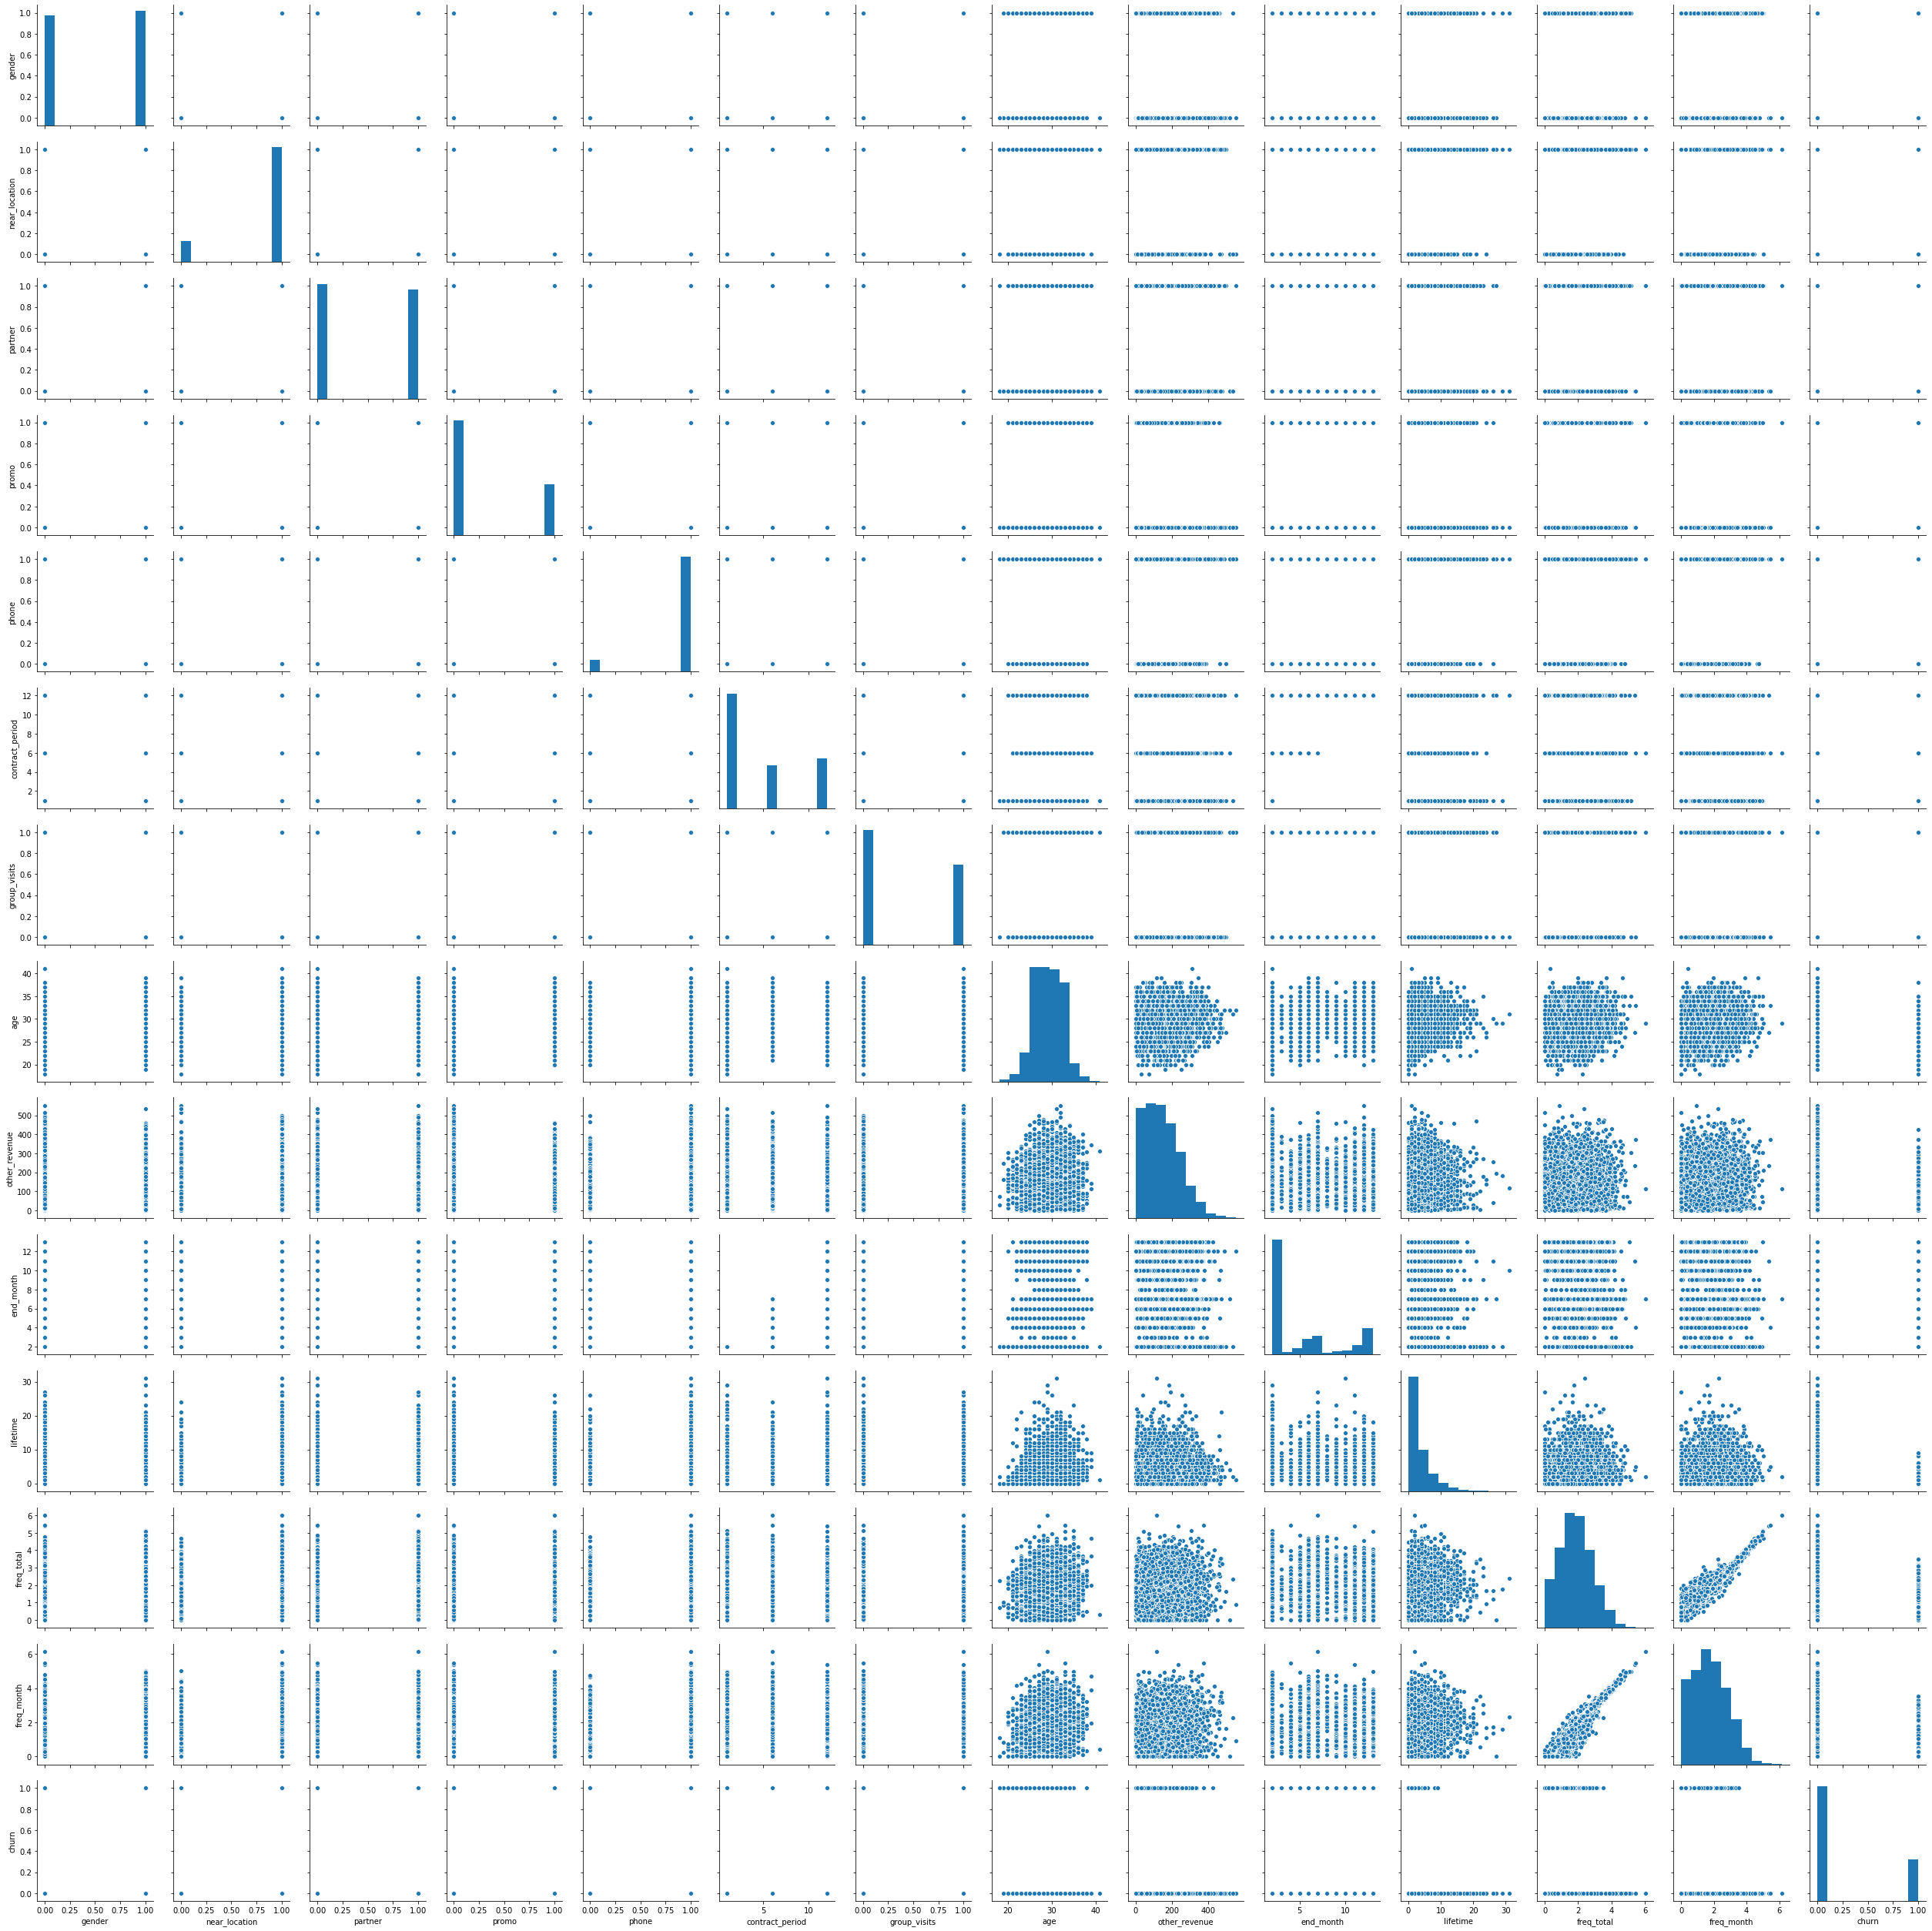

In [8]:
sns.pairplot(data)

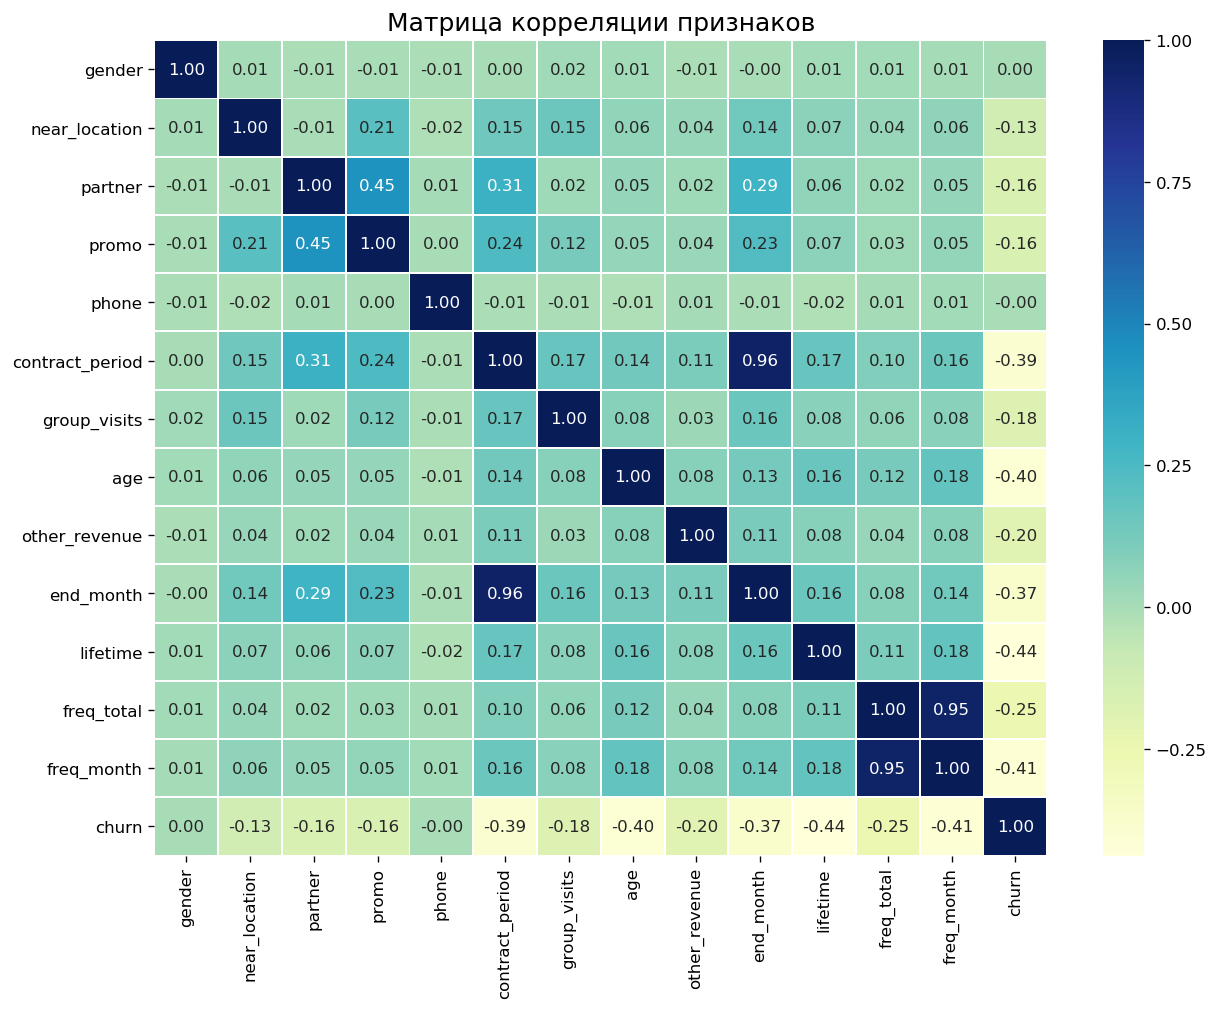

In [9]:
plt.figure(figsize=(12,9), dpi= 120)
plt.title('Матрица корреляции признаков', fontsize=15) 
heat = data.corr()
ax = sns.heatmap(heat, annot=True, fmt='.2f', linewidths=.5, linecolor='white', cmap='YlGnBu')

* единственные колонки, которые сильно коррелируют друг с другом - это contract_period и end_month (количество оставшихся месяцев), что вполне естественно, а так же freq_total и freq_month, здесь так же понятна взаимосвязь, показатели строятся практически на тех же данных, с минимальными различиями.

In [10]:
#количество посетителей в каждом купленном тарифе:
data['contract_period'].value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

* 55% людей пользуются тарифом на месяц, возможно это для них временный вариант, выяснить, что можно сделать, чтобы они захотели более длительные абонементы, но есть вариант, что колонка неправильно размечена и из этих пользователей есть те, у кого 3-х месячный абонемент (обратить внимание коллег);
* 24% пользуются годовыми, а почти 21% полугодовыми абонементами;
* есть проблемы в колонке contract_period - неизвестно количество пользователей пользующихся тарифом на 3 месяца (выяснить у коллег);

In [11]:
#сколько месяцев осталось до конца абонемента (сколько посетителей по каждому количеству месяцев):
data['end_month'].value_counts()

2     2221
7      362
12     313
6      308
13     211
11     181
5      130
10      82
9       73
4       58
8       38
3       23
Name: end_month, dtype: int64

* большинству (55,5%) до конца абонемента осталось 2 месяца, что подверждает ошибочность сведений в колонке о тарифах, там тоже 55% пользуются тарифом  1 месяц (требует выяснения);

In [12]:
# lifetime по месяцам
life = data['lifetime'].value_counts()
#life

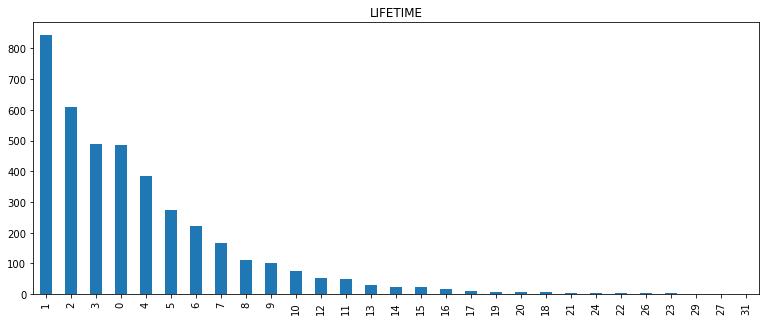

In [13]:
life.plot(kind='bar', figsize=(13, 5), title = 'LIFETIME')

* колонка lifetime не совсем информативна, пока не узнаем, через сколько после первого обращения, посетитель купил абонемент, правда, корреляции с другими колонками не наблюдается, но из графика LIFETIME, видна тенденция к росту количества клиентов, лишь в нынешний (0) месяц она уменьшилась, возможно данные есть не за весь месяц, большинство пользователей пришли в последние 5 месяцев;

In [14]:
#количество отказов:
churn = data.query('churn == 1')
print('Количество отказов:', churn['churn'].count(), '-', (churn['churn'].count())/40, '%')

Количество отказов: 1061 - 26.525 %


* отток составляет 26,5% - очень большой отток;

### 2.2. Корреляция признаков для ушедших пользователей. <a id='102101'></a>

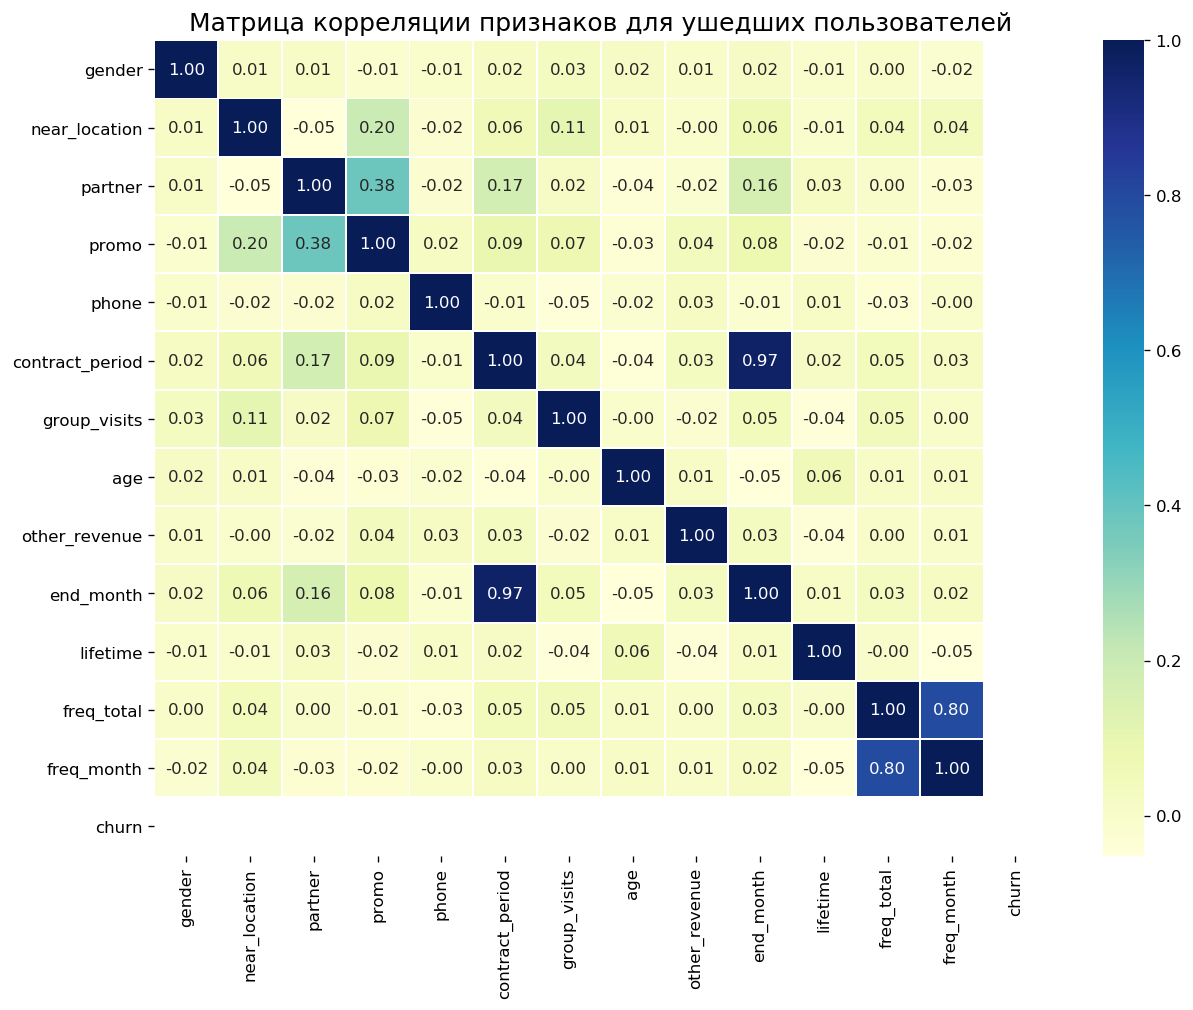

In [15]:
plt.figure(figsize=(12,9), dpi= 120)
plt.title('Матрица корреляции признаков для ушедших пользователей', fontsize=15) 
heat1 = churn.corr()
ax = sns.heatmap(heat1, annot=True, fmt='.2f', linewidths=.5, linecolor='white', cmap='YlGnBu')

In [16]:
#sns.pairplot(churn)

Существует большая связь между периодом контракта и тем, когда кончается абонемент в группе оттока.

### 2.3. Корреляция признаков для оставшихся пользователей. <a id='102102'></a>

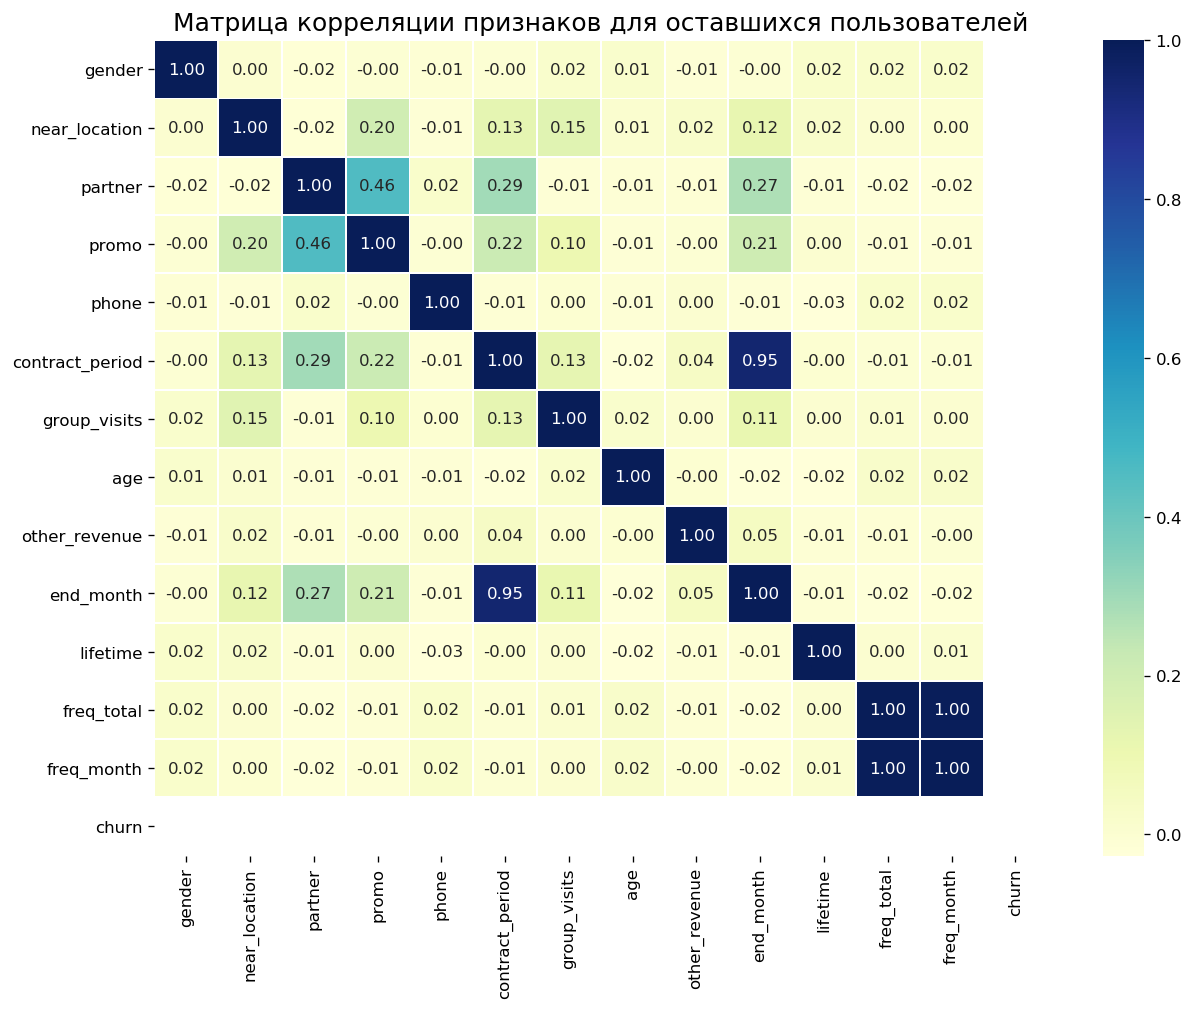

In [17]:
remain = data.query('churn == 0')
plt.figure(figsize=(12,9), dpi= 120)
plt.title('Матрица корреляции признаков для оставшихся пользователей', fontsize=15) 
heat0 = remain.corr()
ax = sns.heatmap(heat0, annot=True, fmt='.2f', linewidths=.5, linecolor='white', cmap='YlGnBu')

In [18]:
#sns.pairplot(remain)

В группе оставшихся так же сильна связь между периодом контракта и тем, когда кончается абонемент и (0.46) между приглашением от посетителей и партнерскими контрактами.

### 2.4. Средние показатели признаков для ушедших пользователей. <a id='102103'></a>

In [19]:
churn.describe()

,gender,near_location,partner,promo,phone,contract_period,group_visits,age,other_revenue,end_month,lifetime,freq_total,freq_month,churn
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.0
mean,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,2.582469,0.990575,1.474995,1.044546,1.0
std,0.500118,0.422217,0.478837,0.387495,0.296204,2.132371,0.443448,2.895163,77.696419,1.782524,1.110799,0.694705,0.770237,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,2.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,50.629127,2.000000,0.000000,1.010771,0.421337,1.0
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,103.814686,2.000000,1.000000,1.491187,0.979445,1.0
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,29.000000,165.616858,2.000000,1.000000,1.956438,1.588576,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,38.000000,425.535220,13.000000,9.000000,3.478646,3.540271,1.0


### 2.5. Средние показатели признаков для оставшихся пользователей. <a id='102104'></a>

In [20]:
remain.describe()

,gender,near_location,partner,promo,phone,contract_period,group_visits,age,other_revenue,end_month,lifetime,freq_total,freq_month,churn
count,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.0
mean,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.888397,4.711807,2.024876,2.027882,0.0
std,0.499984,0.332933,0.498914,0.478144,0.295040,4.716942,0.498795,3.009933,99.801599,4.080679,3.874780,1.016006,1.018994,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,19.000000,0.171862,2.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,28.000000,76.920993,2.000000,2.000000,1.283137,1.297021,0.0
50%,1.000000,1.000000,1.000000,0.000000,1.000000,6.000000,0.000000,30.000000,149.881171,6.000000,4.000000,2.043252,2.046697,0.0
75%,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,32.000000,224.448274,10.000000,6.000000,2.732944,2.740648,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,13.000000,31.000000,6.023668,6.146783,0.0


In [21]:
churn\
.groupby('lifetime')\
['contract_period'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])\
.style.background_gradient('Purples')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning:

invalid value encountered in less



,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
lifetime,,,,,,,,,,,,
0,403,1.62283,1.92823,1,1,1,1,1,1,6,12,12
1,414,1.86473,2.37951,1,1,1,1,1,1,6,12,12
2,157,1.65605,2.03405,1,1,1,1,1,1,6,12,12
3,50,1.6,1.6413,1,1,1,1,1,1,6,6,6
4,23,1.43478,1.44052,1,1,1,1,1,1,1,6,6
5,8,2.25,2.31455,1,1,1,1,1,2.25,6,6,6
6,4,3.75,5.5,1,1,1,1,1,3.75,8.7,11.67,12
8,1,1,nan,1,1,1,1,1,1,1,1,1
9,1,1,nan,1,1,1,1,1,1,1,1,1


### 2.6. Средние значения признаков разделенные по оттоку. <a id='102105'></a>

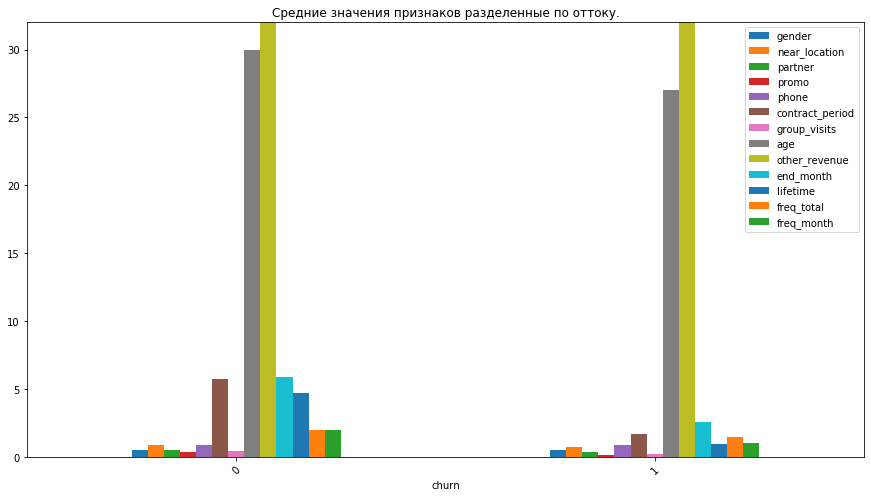

In [22]:
#убираем параметр YLIM и можно увидеть полную картину
data.groupby('churn').mean().plot(kind='bar', rot=45, figsize = (15, 8), ylim=(0, 32), title = ('Средние значения признаков разделенные по оттоку.'))

**Подробнее:**

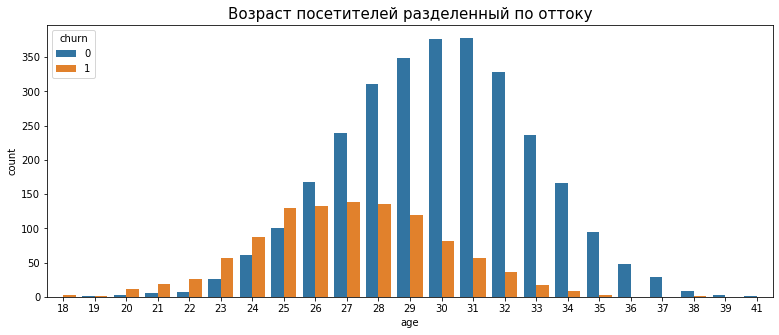

In [23]:
plt.figure(figsize=(13, 5))
sns.countplot(x='age', hue='churn', data=data)
plt.title('Возраст посетителей разделенный по оттоку', fontsize=15) 
plt.show()

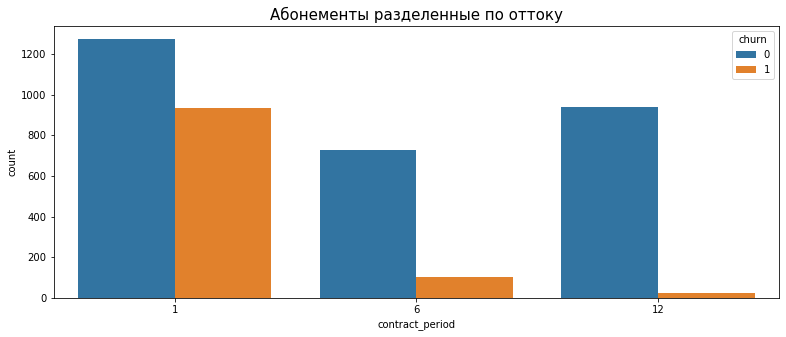

In [24]:
plt.figure(figsize=(13, 5))
sns.countplot(x='contract_period', hue='churn', data=data)
plt.title('Абонементы разделенные по оттоку', fontsize=15) 
plt.show()

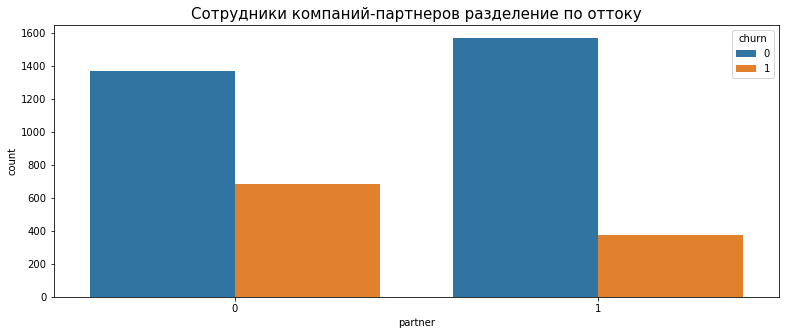

In [25]:
plt.figure(figsize=(13, 5))
sns.countplot(x='partner', hue='churn', data=data)
plt.title('Сотрудники компаний-партнеров разделение по оттоку', fontsize=15) 
plt.show()

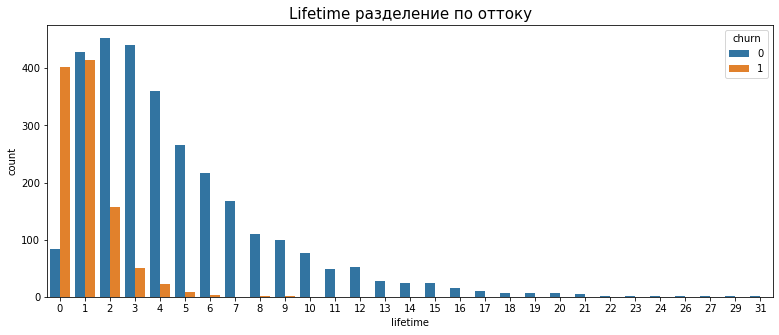

In [26]:
plt.figure(figsize=(13, 5))
sns.countplot(x='lifetime', hue='churn', data=data)
plt.title('Lifetime разделение по оттоку', fontsize=15) 
plt.show()

### 2.7. Предварительные выводы. <a id='102106'></a>

* явно видна взаимосвязь между длительностью купленного абонемента и оттоком, чем короче, тем большая вероятность оттока, большинство из ушедших покупали абонемент на месяц;
* большинство ушедших недавно (в последние 3 мес.) пришли;
* у большинства ушедших до окончания абонемента было менее 3-х месяцев, косвенная связь;
* в последний месяц количество посещений посетителями из группы оттока падало (особенно у тех, кто купил тарифы на 6 и 12 мес.)
* небольшая связь возраста с оттоком, ушедшие в среднем моложе оставшихся;
* есть связь между средним количеством посещений и возможным уходом, те кто не собираются уходить, ходят более 2-х раз в неделю;
* связь дополнительных затрат и оттоком косвенная, кто меньше ходит, тот меньше и покупает;
* большая часть ушедших, пришли в предыдущие 2 месяца и купили тарифный план на 1 месяц и всего сходили в зал от 1 до 3-х раз.

## 7. t-SNE представление данных по оттоку. <a id='100107'></a>

* Раскрасим полученное t-SNE представление данных по оттоку (синие – лояльные, оранжевые – ушедшие клиенты).

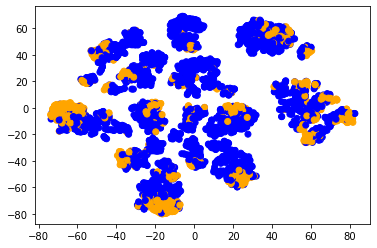

In [27]:
df3 = data[['gender', 'near_location', 'partner', 'promo', 'phone', 'contract_period', 'group_visits', 'age', 'other_revenue', 'end_month', 'lifetime', 'freq_total', 'freq_month']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df3)

tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_scaled)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=data['churn'].map({0: 'blue', 1: 'orange'}));

Видим, что ушедшие клиенты преимущественно "кучкуются" в некоторых областях признакового пространства, жаль, что не в определенной области. Поетому проведем кластеризацию, чтобы выделить особенности ушедших посетителей и понять возможные причины оттока.

## 3. Модель прогнозирования оттока пользователей. <a id='100103'></a>

In [28]:
#Pазобьем данные на обучающую и валидационную выборку функцией train_test_split():

X_train, X_valid, y_train, y_valid = train_test_split(data.drop(columns = ['churn']), data['churn'], 
                                                    test_size = 0.25, random_state = 345)

### 3.1. Модель случайного леса. <a id='103100'></a>

In [29]:
#подберем в цикле лучшие параметры:
for depth in range(9, 16, 1):
    model = RandomForestClassifier(random_state=345, n_estimators=depth)
    model.fit(X_train, y_train)
    report_RFC = classification_report(y_valid, model.predict(X_valid), target_names=['Non-churned', 'Churned'])
    print(depth, report_RFC)

9               precision    recall  f1-score   support

 Non-churned       0.93      0.96      0.94       724
     Churned       0.88      0.81      0.84       276

    accuracy                           0.92      1000
   macro avg       0.90      0.88      0.89      1000
weighted avg       0.91      0.92      0.91      1000

10               precision    recall  f1-score   support

 Non-churned       0.92      0.97      0.94       724
     Churned       0.91      0.77      0.83       276

    accuracy                           0.91      1000
   macro avg       0.91      0.87      0.89      1000
weighted avg       0.91      0.91      0.91      1000

11               precision    recall  f1-score   support

 Non-churned       0.92      0.96      0.94       724
     Churned       0.88      0.79      0.84       276

    accuracy                           0.91      1000
   macro avg       0.90      0.88      0.89      1000
weighted avg       0.91      0.91      0.91      1000

12         

Наиболее оптимальные параметры у модели с 13 деревьями.

In [30]:
model1 = RandomForestClassifier(random_state=345, n_estimators=13)

model1.fit(X_train, y_train)

#предскажем на валидационном датасете:
predictions_valid = model.predict(X_valid)
print(accuracy_score(y_valid, predictions_valid))

0.921


### 3.2. Модель логистической регрессии. <a id='103101'></a>

In [31]:
#масштабируем тренировочный датасет:
X_scaled = preprocessing.scale(X_train)

#создадим модель логистической регрессии:
model_lr = LogisticRegression(random_state=345)

#обучим на тренировочной выборке:
model_lr.fit(X_scaled, y_train)

#предскажем на валидационной:
predictions_valid_lr = classification_report(y_valid, model_lr.predict(X_valid), target_names=['Non-churned', 'Churned'], zero_division=1)
print(report_RFC)

              precision    recall  f1-score   support

 Non-churned       0.92      0.97      0.95       724
     Churned       0.91      0.79      0.85       276

    accuracy                           0.92      1000
   macro avg       0.92      0.88      0.90      1000
weighted avg       0.92      0.92      0.92      1000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [32]:
X_scaled = preprocessing.scale(X_train)

model_lr_1 = LogisticRegression(random_state=345)

model_lr_1.fit(X_train, y_train)

#предскажем на валидационном датасете:
predictions_valid = model_lr_1.predict(X_valid)
print(accuracy_score(y_valid, predictions_valid))

0.922


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Показатели практически идентичны модели случайного леса с 13 деревьями.

**Модели работают, вроде бы, одинаково, но модель логистической регрессии чуть лучше. Выберем её.**

## 4. Кластеризация пользователей. <a id='100104'></a>

In [33]:
# стандартизируем данные
scaler = StandardScaler()
x_sc = scaler.fit_transform(data.drop(columns = ['churn']))

#print(x_sc[:10])
linked = linkage(x_sc, method = 'ward')

### 4.1. Дендрограмма кластеров. <a id='104100'></a>

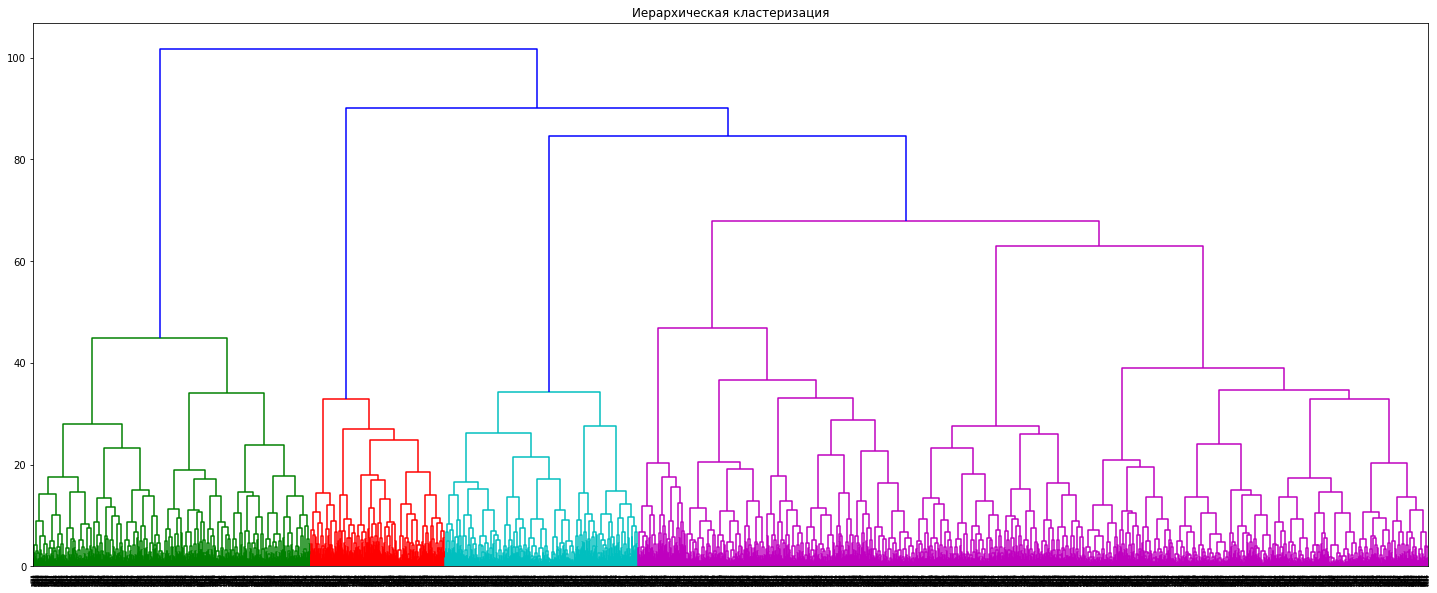

In [34]:
#построим дендрограмму
plt.figure(figsize=(25, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

Из дендрограммы можно сделать вывод, что нужно взять 4 кластера.

******************************
Посмотрим так же на коэффициент силуэта.

In [35]:
#зафиксируем случайность, чтобы каждый раз получалось одно и тоже
np.random.seed(seed=345)

#фиксируем диапазон для количества кластеров
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

#в цикле, используя метод кластеризации K-Means разбиваем данные на указанное число кластеров
#далее, смотрим коэффициент силуэта (внутренняя метрика для оценки качества кластеризации)

for n_clusters in range_n_clusters:
    clustering = KMeans(n_clusters=n_clusters)
    clustering.fit(x_sc)
    silhouette_avg = silhouette_score(x_sc, clustering.labels_)
    print("For n =", n_clusters,
          "clusters, the average silhouette_score is :", silhouette_avg)

For n = 2 clusters, the average silhouette_score is : 0.16474446920681482
For n = 3 clusters, the average silhouette_score is : 0.12570282036138322
For n = 4 clusters, the average silhouette_score is : 0.13395264269869273
For n = 5 clusters, the average silhouette_score is : 0.1405433199979132
For n = 6 clusters, the average silhouette_score is : 0.13466714508465408
For n = 7 clusters, the average silhouette_score is : 0.12822334267624394
For n = 8 clusters, the average silhouette_score is : 0.12664766169753708
For n = 9 clusters, the average silhouette_score is : 0.11712627216111156


Из результата видно, что самое подходящее количество кластеров = 2!, поскольку коэффициент силуэта при нём максимален.

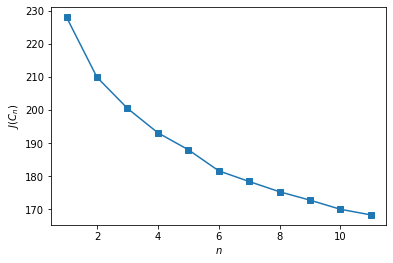

In [36]:
#так же можно убедиться в результате при помощи критерия оценки J(C),
#суммы квадратов расстояний от точек до центроидов кластеров, к которым они относятся

inertia = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k).fit(x_sc)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 12), inertia, marker='s');
plt.xlabel('$n$')
plt.ylabel('$J(C_n)$');

Считаю, что при разделении датасета по оттоку, уже были видны некоторые закономерности, так что теперь посмотрим все же на 4 кластера. Возможно, можно будет добыть дополнительную информацию.

### 4.2. K-means. Статистика значений кластера. <a id='104101'></a>

In [37]:
# задаём модель k_means с числом кластеров 4
km = KMeans(random_state=345, n_clusters = 4)

# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
data.groupby('cluster_km').mean().T

cluster_km,0,1,2,3
gender,0.479137,0.556830,0.516833,0.494565
near_location,1.000000,0.981230,0.955414,0.000000
partner,0.359712,0.352450,0.777070,0.461957
promo,0.240288,0.250261,0.562329,0.076087
phone,0.900719,0.905109,0.898999,0.916667
contract_period,1.997842,2.722628,10.989991,2.280797
group_visits,0.343165,0.467153,0.550500,0.215580
age,28.197122,30.083420,29.989991,28.503623
other_revenue,130.835575,159.738720,162.450246,134.404362
end_month,2.766187,3.291971,10.363967,2.996377


В двух кластерах уже происходит активный отток - это 0 (52% ушли) и 3 (44% ушли). Кластеры 1 и 2 - надежны. По 1 и 2 кластерам можно составить портреты посетителей.

Склонны к оттоку:

* проживающие не близко;
* купившие абонемент на 1 месяц;
* не посещающие групповые занятия;
* тратящие мало денег дополнительно;
* более молодые посетители (менее 28 лет требует дальнейшего выяснения);
* у кого кончается абонемент;
* те кто пришли менее 3-х месяцев назад;
* кто ходит менее 1,5 раз в неделю, а в последний месяц стали ходить еще меньше.

Надежны:

* живущие рядом;
* купившие абонемент через работодателя;
* пришедшие по приглашению друзей;
* купившие "долгий" абонемент (от 6 до 12 месяцев);
* посещающие групповые занятия;
* покупающие больше дополнительных услуг;
* у кого абонемент еще только начался (длительные);
* кто пришел давно (от 4-5 месяцев назад);
* кто ходит более 1,9 раз в неделю - стабильно.

### 4.3. График для пары признаков "дополнительные расходы" и "частота посещений за все время"
<a id='104102'></a>

In [38]:
# определим функцию отрисовки графиков попарных признаков для кластеров:
def show_clusters_on_plot(data, x_name,y_name, cluster_name):
    plt.figure(figsize = (12,12))
    sns.scatterplot(data[x_name], data[y_name],
           hue = data[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    sns.despine()
    plt.show()

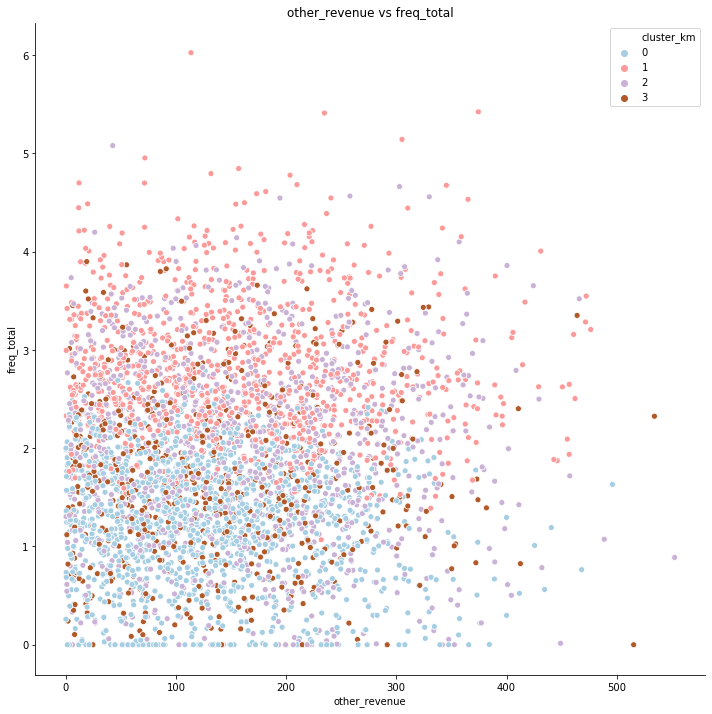

In [39]:
# отрисуем график для пары признаков "дополнительные расходы" и "частота посещений за все время"
show_clusters_on_plot(data,
                      'other_revenue',
                      'freq_total',
                      'cluster_km')

Есть явное разделение между 0-м и 1-м кластерами по частоте походов в зал за все время.

### 4.4. График для пары признаков "lifetime" и "срок до окончания абонемента". <a id='104103'></a>

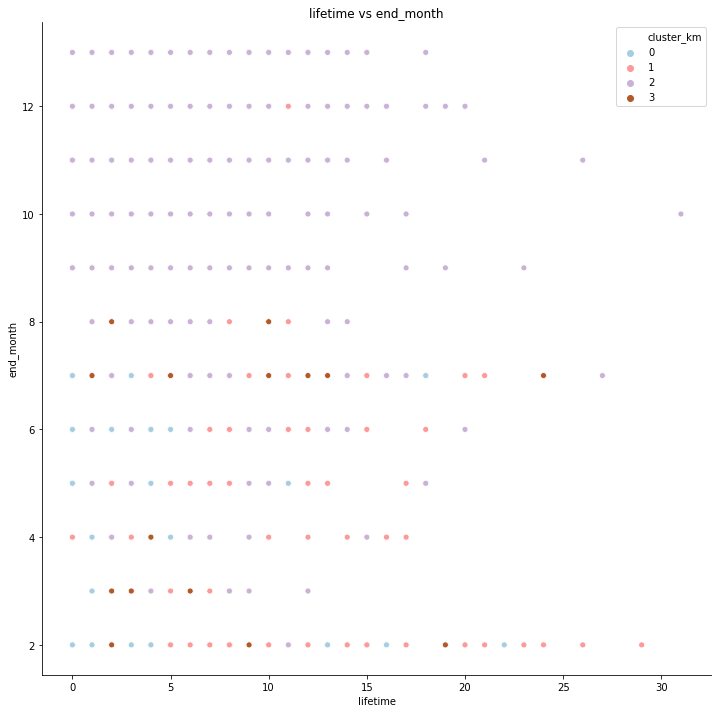

In [40]:
# отрисуем график для пары признаков "lifetime" и "срок до окончания абонемента"
show_clusters_on_plot(data,
                      'lifetime',
                      'end_month',
                      'cluster_km')

2-й кластер преобладет в категории от 8 месяцев оставшихся

### 4.5. График для пары признаков "другие расходы" и "возраст". <a id='104104'></a>

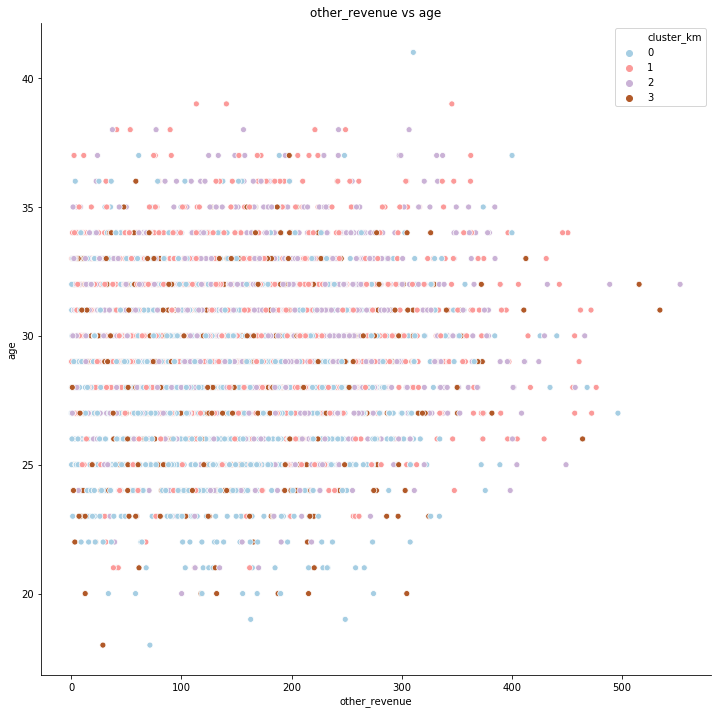

In [41]:
# отрисуем график для пары признаков "другие расходы" и "возраст"
show_clusters_on_plot(data,
                      'other_revenue',
                      'age',
                      'cluster_km')

0-й кластер преобладает в группе до 30 лет. 1 и 2-й преобладают в группе от 25 лет.

### 4.6. График для пары признаков "частота посещений за все время" и "частота посещений в последний месяц". <a id='104105'></a>

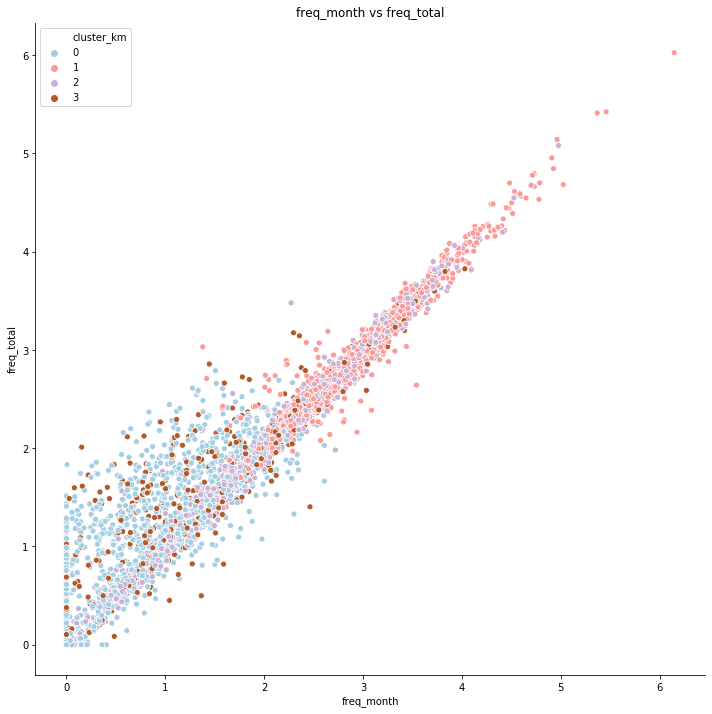

In [42]:
# отрисуем график для пары признаков "частота посещений за все время" и "частота посещений в последний месяц"
show_clusters_on_plot(data,
                      'freq_month',
                      'freq_total',
                      'cluster_km')

Видно разделение между кластерами 0 (до 2-х посещений) и 1 (от 2 до 5 посещений).

In [43]:
cluster_0 = data.query('cluster_km == 0 and churn == 1')
cluster_1 = data.query('cluster_km == 1 and churn == 1')
cluster_2 = data.query('cluster_km == 2 and churn == 1')
cluster_3 = data.query('cluster_km == 3 and churn == 1')
c0 = data.query('cluster_km == 0')
c1 = data.query('cluster_km == 1')
c2 = data.query('cluster_km == 2')
c3 = data.query('cluster_km == 3')
print('Число ушедших пользователей из 0-го кластера:', len(cluster_0), ', доля:', round((len(cluster_0) / len(c0))*100), '%')
print('Число ушедших пользователей из 1-го кластера:', len(cluster_1), ', доля:', round((len(cluster_1) / len(c1))*100), '%')
print('Число ушедших пользователей из 2-го кластера:', len(cluster_2), ', доля:', round((len(cluster_2) / len(c2))*100), '%')
print('Число ушедших пользователей из 3-го кластера:', len(cluster_3), ', доля:', round((len(cluster_3) / len(c3))*100), '%')

Число ушедших пользователей из 0-го кластера: 716 , доля: 52 %
Число ушедших пользователей из 1-го кластера: 71 , доля: 7 %
Число ушедших пользователей из 2-го кластера: 29 , доля: 3 %
Число ушедших пользователей из 3-го кластера: 245 , доля: 44 %


**Надежен 2 кластер. 3 и 0 кластеры склонны к оттоку.**

## 5. Выводы. <a id='100105'></a>

1. 84,5% посетителей живут поблизости;
2. 51% являются сотрудниками компаний-партнеров;
3. 31% впервые пришли по промокоду от друзей;
4. Телефоны 90% посетителей известны;
5. 24% пользуются годовыми, а почти 21% полугодовыми абонементами;
6. 59% посещают групповые программы, скорее всего большинство из них женщины **(проверить)**;
7. Возраст посетителей от 18 до 41 года, средний возраст большинства от 23 до 35 лет;
8. 94% людей хоть раз что-то покупали в центре дополнительно, средняя выручка 140 р.;
9. Средняя частота посещений в неделю за все время - 1.8;
10. Средняя частота посещений в неделю за последний месяц - 1.7;
11. Количество отказов: 1061 - 26.525 % **очень большой отток**;
12. Надежен 2 кластер, возможен отток в 1 кластер3, в 0 и 3 уже идет интенсивный отток.

## 6. Базовые рекомендации по работе с клиентами. <a id='100106'></a>

55% людей пользуются тарифом на месяц, возможно это для них временный вариант, выяснить, что можно сделать, чтобы они захотели более длительные абонементы, но есть вариант, что колонка неправильно размечена и из этих пользователей есть те, у кого 3-х месячный абонемент **(обратить внимание коллег)!**

В колонке contract_period - неизвестно количество пользователей пользующихся тарифом на 3 месяца **(выяснить у коллег)!**

Большинству (55,5%) до конца абонемента осталось 2 месяца, что подверждает возможную ошибочность сведений в колонке о тарифах, там тоже 55% пользуются тарифом  1 месяц **(требует выяснения)!**

Большой отток за последний месяц - **выяснить причины!**


Первоочередные категории:
* отслеживать 1 кластер, чтобы не допустить оттока (он в группе риска),
* отслеживать когорты новых (моложе 3-х месяцев) посетителей,
* отслеживать, когда у посетителя начинаются последние 3 месяца абонемента,
* отслеживать, если посетитель мало ходит (менее 2 визитов в неделю) или начинает в месяце ходить менее 1.5 раз в неделю,

Для таких пользователей разработать индивидуальные программы по привлечению:
* делать скидки на абонементы более 6 месяцев (такие люди менее склонны к оттоку),
* стимулировать посещение групповых программ (установление связей с другими посетителями, будет стимулировать посещения),
* промоакции ориентированные на 30-летних.
* людей приходящих от друзей в 2 раза меньше среди людей живущих рядом, чем среди людей работающих вместе. Стимулирование приглашений среди посетителей просто живущих рядом.
* стимулирование продаж в 1 и 2 кластерах, возможно скидки для пользователей длительных тарифов.

Обе модели машинного обучения  работают одинаково, в принципе, можно будет выбрать любую, в зависимости от технических возможностей.